<a href="https://colab.research.google.com/github/MoazMuhammed/ecommerce/blob/master/notebooka4e93fd809.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")

zip_ref.extractall()
zip_ref.close()

--2023-05-07 07:48:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.69.128, 64.233.182.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   303MB/s    in 1.6s    

2023-05-07 07:48:18 (303 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib 
import numpy as np

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/New folder/train"
test_dir = "/content/drive/MyDrive/New folder/test"
data_dir = pathlib.Path('/content/drive/MyDrive/New folder/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))



print(class_names)


['Burger' 'Dairy product' 'Donut' 'Egg' 'Meat' 'Noodles-Pasta' 'Pizza'
 'Sandwich' 'Seafood' 'cake' 'hotDog' 'sushi']


In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
# Resnet 50 V2 feature vector
# resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img
# Create a function to import an image and resize it to be able to be used with our model


def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

 

In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=20, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

NameError: ignored

In [ ]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 12)                15372     
                                                                 
Total params: 4,064,936
Trainable params: 15,372
Non-trainable params: 4,049,564
_________________________________________________________________


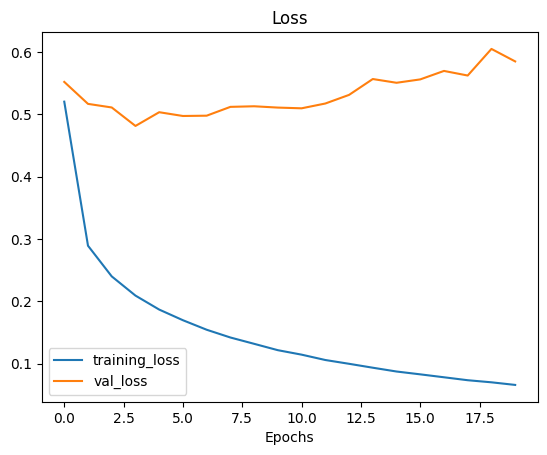

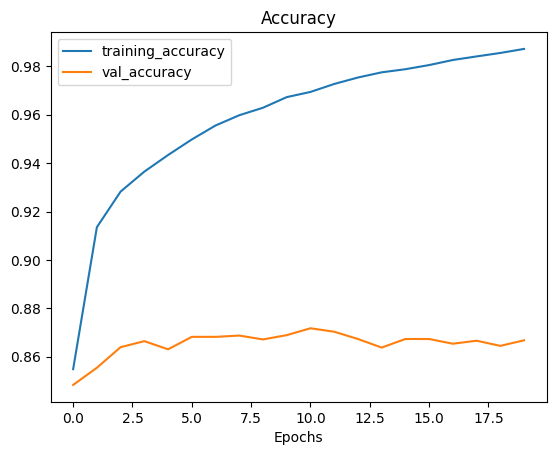

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:

pred_and_plot(efficientnet_model,"/kaggle/input/fdsafads/ph.jpg",class_names)

NotFoundError: ignored

In [ ]:

pred_and_plot(e,"https://media-cdn.tripadvisor.com/media/photo-s/19/1e/1a/3a/pizza-hut.jpg",class_names)


NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
im_name ="/content/drive/MyDrive/s.jpeg"
sign = load_and_prep_image(im_name)

sign = tf.expand_dims(sign, axis=0) # add an extra dimension at axis 0

prediction = efficientnet_model.predict(sign)

# m = sorted(pred[0].tolist())[-1]
# n = (pred[0].tolist()).index(m)

# pre = pred[0][n]

# pred_class = class_names[n]
# pred_class
# prediction = efficientnet_model.predict(np.array([im_name]))[0]
predicted_class_index = np.argmax(prediction)
predicted_class_name = class_names[predicted_class_index]
# print(f"Predicted class: {predicted_class_name} (probability: {prediction[predicted_class_index]:.2f})")

predicted_class_index 

NameError: ignored

In [ ]:
# efficientnet_model.save('my_model1.h5')

from tensorflow.keras.models import save_model

save_model(efficientnet_model, 'model.h5')



In [ ]:
# from efficientnet.tfkeras import EfficientNetB0
# import tensorflow_hub as hub
# custom_objects = {'KerasLayer': hub.EfficientNetB0}

# # import efficientnet.tfkeras as efn

# # custom_objects={'EfficientNetB0': '/content/tensorflow_hub'}

# tf.keras.models.load_model('my_model1.h5', custom_objects=custom_objects)


from tensorflow.keras.models import load_model

efficientnetb0_model = load_model('model.h5')



OSError: ignored

In [ ]:
!pip install efficientnet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
# # Save the efficientnet_model
# efficientnet_model.save('efficientnet_model.h5')
import tensorflow as tf
import tensorflow_hub as hub

# Load the efficientnet_model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model.h5', 
                                           custom_objects={'KerasLayer': hub.KerasLayer})

# # Compile the loaded model
# loaded_model.compile(loss='categorical_crossentropy',
#                       optimizer=tf.keras.optimizers.Adam(),
#                       metrics=['accuracy'])

# # Evaluate the loaded model
# loaded_model.evaluate(test_data)

In [ ]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img
# Create a function to import an image and resize it to be able to be used with our model




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
im_name ="/content/drive/MyDrive/555.jpg"
sign = load_and_prep_image(im_name)

sign = tf.expand_dims(sign, axis=0) # add an extra dimension at axis 0

prediction = loaded_model.predict(sign)


predicted_class_index = np.argmax(prediction)
predicted_class_name = class_names[predicted_class_index]
# print(f"Predicted class: {predicted_class_name} (probability: {prediction[predicted_class_index]:.2f})")

predicted_class_index 

1/1 [==============================] - 0s 89ms/step


0

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['Burger', 'Dairy product', 'Donut', 'Egg', 'Meat', 'Noodles-Pasta',
       'Pizza', 'Sandwich', 'Seafood', 'cake', 'hotDog', 'sushi'],
      dtype='<U13')